# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles.

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée](#section_2)

[3. Approche supervisée](#section_3)

[4. Approche supervisée avec Word Embedding : Word2Vec](#section_4)

[5. Approche supervisée avec Word Embedding : BERT](#section_5)

[6. Approche supervisée avec Sentence Embedding : USE](#section_6)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [54]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [55]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'saved_ressources/')
files

['bows.mm',
 'bows.mm.index',
 'bows1.mm',
 'bows1.mm.index',
 'bows2.mm',
 'bows2.mm.index',
 'data_cleaned.csv']

In [56]:
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned.csv', encoding='utf8')

In [57]:
data = data.applymap(lambda x: ast.literal_eval(x))

In [58]:
data.head()

,Tags,Texts
0,"[macos, emacs, scheme, interpreter, sicp]","[scheme, interpreter, interpreter, python, int..."
1,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,..."
2,"[mysql, database, arrays, postgresql, stored-p...","[pass, array, procedure, pass, array, procedur..."
3,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, buttonwithtype, figure, button, state,..."
4,"[database, nhibernate, exception-handling, con...","[check, application, column, constraint, colum..."


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159599 entries, 0 to 159598
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Tags    159599 non-null  object
 1   Texts   159599 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


Le jeu de données est trop important pour les temps de calculs à ma disposition.

J'ai deux possibilités : 
- prendre un sample de 5000 observations aléatoirement
- prendre les 5000 observations pour lesquelles la similarité entre les deux colonnes est importante

In [60]:
# data_sample = data.sample(1000)
# data_sample.reset_index(inplace=True, drop=True)
# print(data_sample.shape)
# data_sample.head()

In [61]:
from typing import List

In [62]:
def jaccard_similarity(list1: List[str], list2: List[str]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

def get_highest_similarity_rows(data: pd.DataFrame, col1: str, col2: str, n: int):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)


data_sample = get_highest_similarity_rows(data, "Tags", "Texts", 2000)
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(2000, 2)


,Tags,Texts
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da..."
1,"[listview, javafx, tableview, scrollbar, hide]","[hide, scrollbar, listview, javafx, hide, scro..."
2,"[jpa, merge, entitymanager, persist, java-pers...","[jpa, entitymanager, merge, entitymanager, mer..."
3,"[python, django, image, gallery, portfolio]","[create, image, gallery, create, portfolio, dj..."
4,"[python, authentication, proxy, https, ntlm]","[python, https, proxy, ntlm, authentication, s..."


In [63]:
texts_list = data_sample["Texts"].to_list()
tags_list = data_sample["Tags"].to_list()

In [64]:
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]

In [65]:
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

## <font color="#114b98" id="section_2">2. Approche non supervisée</font>

In [66]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [15]:
def determine_optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test, and the list of texts,
    applies the models to the data and plots the silhouette and coherence scores to help 
    determine the optimal number of topics.
    
    """

    # Vectorize the data
    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    # Initialize lists to store scores for LDA and NMF
    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    # Loop through the range of number of topics
    for n_topics in n_topics_range:
        
        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, max_iter=300)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=300)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())
            
        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())
     
    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'], 
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    plt.suptitle('Silhouette and Coherence Scores for LDA and NMF with {}'.format(str(vectorizer).split('(')[0]))
    
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()

    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()

    plt.show()
    
    return scores

In [132]:
# Define the range of number of topics to test
n_topics_range = range(2, 18, 3)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

In [133]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

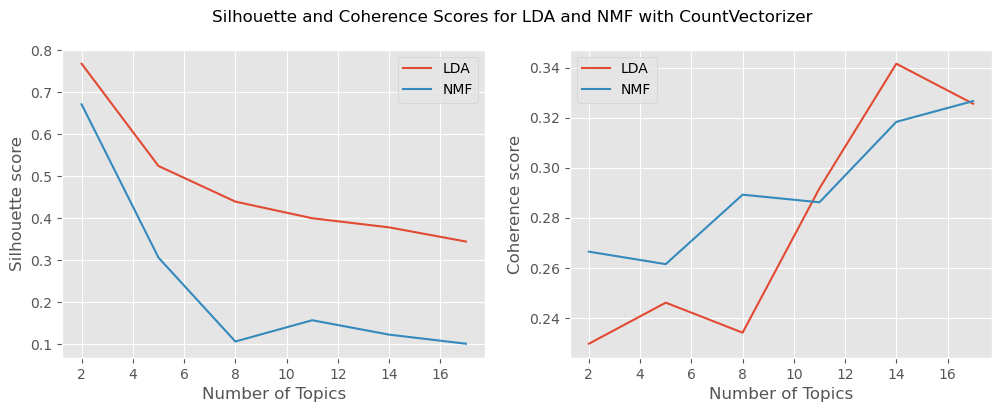

In [18]:
nmf_and_lda_models_with_CountVectorizer = determine_optimal_num_topics(flat_texts, vectorizer, n_topics_range, texts_list)

In [19]:
nmf_and_lda_models_with_CountVectorizer

,topics_silhouette,score_silhouette,topics_coherence,score_coherence
LDA,2,0.767908,14,0.341525
NMF,2,0.671208,17,0.326609


TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

In [21]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

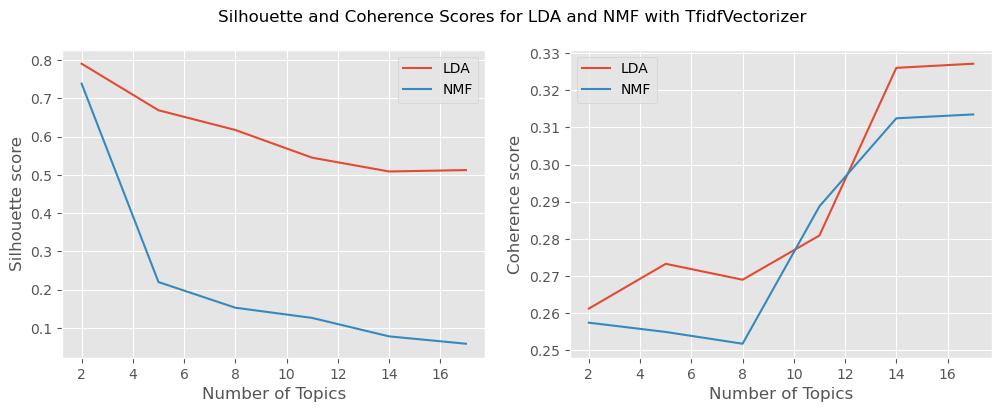

In [22]:
nmf_and_lda_models_with_TfidfVectorizer= determine_optimal_num_topics(flat_texts, vectorizer, n_topics_range, texts_list)

In [23]:
nmf_and_lda_models_with_TfidfVectorizer

,topics_silhouette,score_silhouette,topics_coherence,score_coherence
LDA,2,0.790615,17,0.327189
NMF,2,0.738618,17,0.313517


Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils sont plus "interprétables par les humains".

Nous devons maintenant essayer d'obtenir des tags en utilisant ces méthodes.

Je choisis d'utiliser uniquement LDA pour la suite car c'est la méthode qui obtient les meilleurs scores.

Le paramètre min_df définit le nombre minimum de documents dans lesquels un mot doit être présent pour être inclus dans le vocabulaire.

In [67]:
min_df=25

Le paramètre max_df définit la fréquence maximale d'un mot en pourcentage de tous les documents. 

In [68]:
max_df=0.5

In [69]:
n_topics = 7

In [70]:
def get_tags_from_text(texts_list, flat_texts, n_topics, vocabulary_texts, min_df, max_df):
    
    # Predict tags using LdaModel (gensim) without bow or TF-IDF 
    predicted_tags_gensim = list()
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42)
    for text in texts_list:
        bow = dictionary.doc2bow(text)
        topics = lda.get_document_topics(bow, minimum_probability=0)
        topic_id, prob = max(topics, key=lambda x: x[1])
        topic_words = [w for w, p in lda.show_topic(topic_id, topn=5)]
        predicted_tags_gensim.append(topic_words)

    # Predict tags using LDA (sklearn) without bow or TF-IDF  
    predicted_tags_sklearn = list()
    corpus_dense = corpus2dense(corpus, num_terms=len(dictionary)).T
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(corpus_dense)
    for text in texts_list:
        bow = dictionary.doc2bow(text)
        dense_bow = corpus2dense([bow], num_terms=len(dictionary)).T[0]
        dense_bow = np.reshape(dense_bow, (1, -1))
        topic_distribution = lda.transform(dense_bow)
        topic_id = topic_distribution.argmax()
        top_words_indices = np.argsort(-lda.components_[topic_id])[:5]
        topic_words = [dictionary[i] for i in top_words_indices]
        predicted_tags_sklearn.append(topic_words)     
        
    # Predict tags using LdaModel with TF-IDF 
    predicted_tags_tfidf = list()
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, vocabulary=vocabulary_texts)
    bow_matrix = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(bow_matrix)
    for text in texts_list:
        bow = vectorizer.transform(text)
        topics = lda.transform(bow)
        topic_id = topics.argmax(axis=1)[0]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[:, topic_id].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        predicted_tags_tfidf.append(topic_words)
        
    # Predict tags using LdaModel with CountVectorizer 
    predicted_tags_count = list()
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, vocabulary=vocabulary_texts)
    bow_matrix = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(bow_matrix)
    for text in texts_list:
        bow = vectorizer.transform(text)
        topics = lda.transform(bow)
        topic_id = topics.argmax(axis=1)[0]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[:, topic_id].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        predicted_tags_count.append(topic_words)    
        
    return predicted_tags_gensim, predicted_tags_sklearn, predicted_tags_tfidf, predicted_tags_count

In [71]:
predicted_tags_gensim, predicted_tags_sklearn, predicted_tags_tfidf, predicted_tags_count = get_tags_from_text(texts_list,
                                                                                                               flat_texts,
                                                                                                               n_topics,
                                                                                                               vocabulary_texts,
                                                                                                               min_df,
                                                                                                               max_df)

In [72]:
tags_list[0:5]

[['javascript', 'jquery', 'string', 'date', 'object'],
 ['listview', 'javafx', 'tableview', 'scrollbar', 'hide'],
 ['jpa', 'merge', 'entitymanager', 'persist', 'java-persistence-api'],
 ['python', 'django', 'image', 'gallery', 'portfolio'],
 ['python', 'authentication', 'proxy', 'https', 'ntlm']]

In [73]:
predicted_tags_gensim[0:5]

[['java', 'python', 'date', 'function', 'javascript'],
 ['list', 'time', 'json', 'java', 'way'],
 ['difference', 'way', 'file', 'python', 'function'],
 ['list', 'time', 'json', 'java', 'way'],
 ['difference', 'way', 'file', 'python', 'function']]

In [74]:
predicted_tags_sklearn[0:5]

[['date', 'java', 'time', 'python', 'datetime'],
 ['list', 'json', 'way', 'python', 'field'],
 ['file', 'jquery', 'use', 'javascript', 'css'],
 ['date', 'java', 'time', 'python', 'datetime'],
 ['difference', 'spring', 'way', 'database', 'hibernate']]

In [75]:
predicted_tags_tfidf[0:5]

[['mongoose', 'outline', 'timedelta', 'nsscrollview', 'lightgray'],
 ['lightgray', 'style', 'laurent', 'algorithm', 'rdflib'],
 ['style', 'laurent', 'algorithm', 'rdflib', 'zero'],
 ['timedelta', 'nsscrollview', 'lightgray', 'style', 'laurent'],
 ['tasklist', 'referenceerror', 'whitespace', 'mongoose', 'outline']]

In [76]:
predicted_tags_count[0:5]

[['mongoose', 'outline', 'timedelta', 'nsscrollview', 'lightgray'],
 ['lightgray', 'style', 'laurent', 'algorithm', 'rdflib'],
 ['style', 'laurent', 'algorithm', 'rdflib', 'zero'],
 ['timedelta', 'nsscrollview', 'lightgray', 'style', 'laurent'],
 ['tasklist', 'referenceerror', 'whitespace', 'mongoose', 'outline']]

can you show me on my code how to implement this ?

Another possible issue is that the second block of code is not passing in the individual text to the vectorizer's transform() method but the whole dataset, this will cause the model to consider the whole dataset as the text to predict and not the individual text.

Also, the way you are retrieving the topic words from the model is not the most efficient way. You can use the components_ attribute of the fitted LDA model to get the topic-word distribution, which you can then use to get the top words for each topic.

## <font color="#114b98" id="section_3">3. Approche supervisée</font>

In [77]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, jaccard_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [142]:
mlb = MultiLabelBinarizer(classes=vocabulary_tags)

In [150]:
tags_mlb = mlb.fit_transform(flat_tags)

In [145]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               MultinomialNB()]

 - Accuracy: mesure de combien de prédictions faites par le modèle sont correctes
 - Precision: mesure combien des prédictions positives faites par le modèle sont effectivement correctes. Un score de précision élevé signifie que le modèle fait peu de prédictions positives fausses.
 - Recall: mesure combien des exemples positifs réels sont correctement prédits par le modèle. Un score de rappel élevé signifie que le modèle est capable de trouver la plupart des exemples positifs.
 - F1 Score: mesure de l'exactitude d'un modèle, il est un moyen harmonique de précision et de rappel. Il varie de 0 à 1, où un score proche de 1 indique une meilleure performance et un score proche de 0 indique une performance moins bonne. 
 - Jaccard Score: mesure de la similarité entre les deux ensembles de prédictions et de vraies étiquettes. Il varie de 0 à 1, où un score proche de 1 indique une très grande similitude et un score proche de 0 indique une grande dissimilarité.

In [146]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers):
    
    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Jaccard Score'])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
    
    # Vectorize X_train and X_test
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for classifier in classifiers:
        ovrc = OneVsRestClassifier(classifier)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)
        
        accuracy = round(accuracy_score(y_test, y_pred_ovrc), 4)
        precision = round(precision_score(y_test, y_pred_ovrc, average='samples'), 4)
        recall = round(recall_score(y_test, y_pred_ovrc, average='samples'), 4)
        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)
        
        results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                       'Accuracy': accuracy, 
                                       'Precision': precision, 
                                       'Recall': recall, 
                                       'F1 Score': f1, 
                                       'Jaccard Score': jaccard}, 
                                       ignore_index=True)
                                       
        print('Results for classifier:', classifier)
        print("Accuracy : ", accuracy)
        print("Precision : ", precision)
        print("Recall : ", recall)
        print("F1 Score : ", f1)
        print("Jaccard Score:", jaccard)
        print('\n')
        
    return results_df

In [147]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

In [148]:
results_df_CountVectorizer = calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers)

Results for classifier: LogisticRegression(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.63
Precision :  0.8683
Recall :  0.8575
F1 Score :  0.8404
Jaccard Score: 0.79


Results for classifier: SGDClassifier(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.5525
Precision :  0.8408
Recall :  0.8175
F1 Score :  0.8022
Jaccard Score: 0.7425


Results for classifier: RandomForestClassifier(random_state=42)
Accuracy :  0.6725
Precision :  0.8479
Recall :  0.9429
F1 Score :  0.8752
Jaccard Score: 0.8283


Results for classifier: KNeighborsClassifier()
Accuracy :  0.56
Precision :  0.8358
Recall :  0.8892
F1 Score :  0.8361
Jaccard Score: 0.7733


Results for classifier: MultinomialNB()
Accuracy :  0.625
Precision :  0.8379
Recall :  0.8846
F1 Score :  0.8401
Jaccard Score: 0.7892




In [151]:
results_df_CountVectorizer

,Classifier,Accuracy,Precision,Recall,F1 Score,Jaccard Score
0,LogisticRegression,0.6300,0.8683,0.8575,0.8404,0.7900
1,SGDClassifier,0.5525,0.8408,0.8175,0.8022,0.7425
2,RandomForestClassifier,0.6725,0.8479,0.9429,0.8752,0.8283
3,KNeighborsClassifier,0.5600,0.8358,0.8892,0.8361,0.7733
4,MultinomialNB,0.6250,0.8379,0.8846,0.8401,0.7892


Obtenir des scores de précision élevés, de rappel élevés, de F1 élevés et de Jaccard élevés, mais des scores de précision faibles montre que les données sont déséquilibrées. Cela signifie qu'il y a un grand déséquilibre entre les différentes classes. Dans ce cas, un classificateur qui prédirait toujours la classe majoritaire aurait un taux de précision élevé mais un taux global de précision faible, car il ignore la classe minoritaire.

In [152]:
def plot_results(results_df):
    
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(1, 5, figsize=(20,5))
    
    # Set a color palette
    my_palette = sns.color_palette("husl", 5)
    
    # Set the x-axis to be a range of numerical values
    x = range(len(results_df))
    scoring_methods = ['Accuracy','Precision','Recall','F1 Score','Jaccard Score']
    
    # Create a bar plot for each subplot
    sns.barplot(x='Classifier', y='Accuracy', data=results_df, ax=axs[0], palette=my_palette, label='Accuracy')
    sns.barplot(x='Classifier', y='Precision', data=results_df, ax=axs[1], palette=my_palette, label='Precision')
    sns.barplot(x='Classifier', y='Recall', data=results_df, ax=axs[2], palette=my_palette, label='Recall')
    sns.barplot(x='Classifier', y='F1 Score', data=results_df, ax=axs[3], palette=my_palette, label='F1 Score')
    sns.barplot(x='Classifier', y='Jaccard Score', data=results_df, ax=axs[4], palette=my_palette, label='Jaccard Score')
    
    # Add classifier names to x-axis
    for i in range(5):
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(results_df['Classifier'], rotation=90)
        axs[i].set_xlabel('Classifier')
        axs[i].set_ylabel('Score')
        axs[i].set_title(scoring_methods[i])
    plt.show()

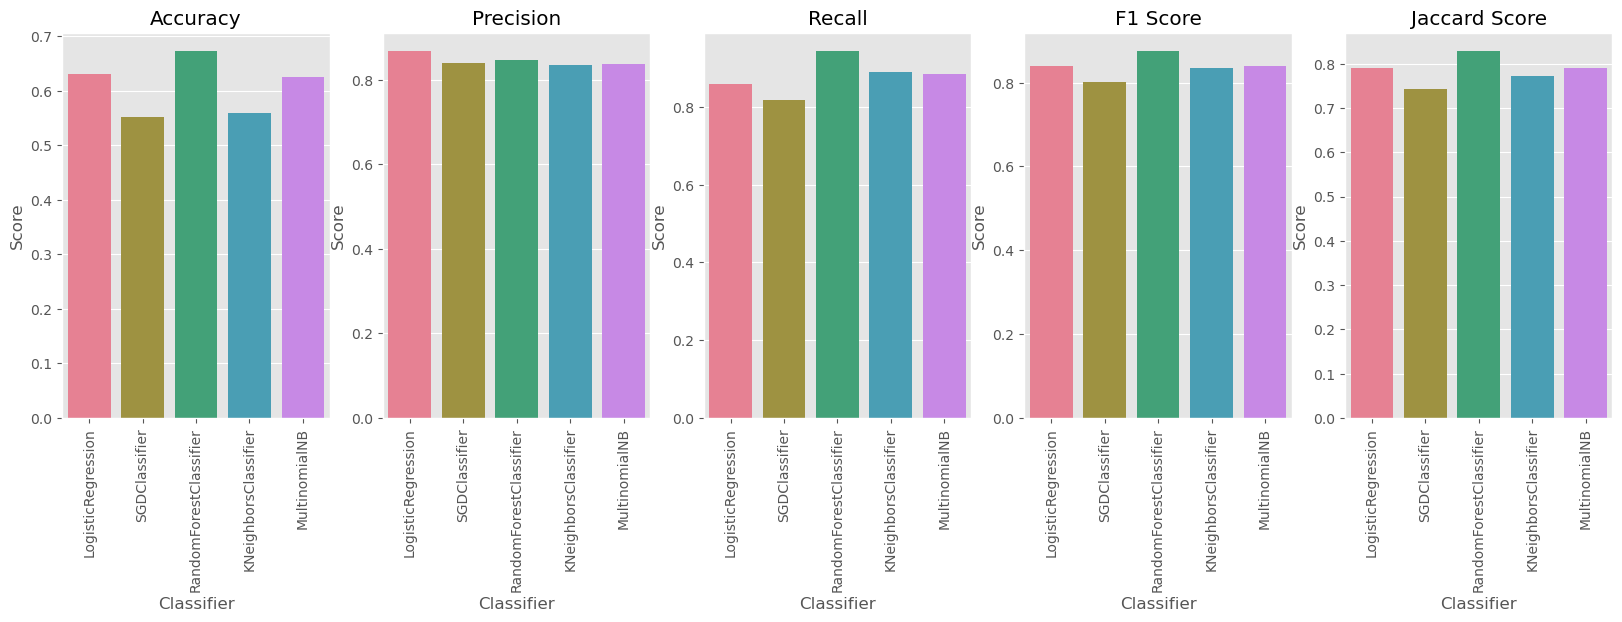

In [153]:
# Call the plot_results function
plot_results(results_df_CountVectorizer)

In [154]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

In [155]:
results_df_TfidfVectorizer = calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers)

Results for classifier: LogisticRegression(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.6125
Precision :  0.845
Recall :  0.8938
F1 Score :  0.8482
Jaccard Score: 0.7938


Results for classifier: SGDClassifier(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.56
Precision :  0.8512
Recall :  0.7775
F1 Score :  0.788
Jaccard Score: 0.7329


Results for classifier: RandomForestClassifier(random_state=42)
Accuracy :  0.6675
Precision :  0.845
Recall :  0.9417
F1 Score :  0.8727
Jaccard Score: 0.825


Results for classifier: KNeighborsClassifier()
Accuracy :  0.5675
Precision :  0.8325
Recall :  0.8929
F1 Score :  0.837
Jaccard Score: 0.7762


Results for classifier: MultinomialNB()
Accuracy :  0.5875
Precision :  0.8354
Recall :  0.9038
F1 Score :  0.8476
Jaccard Score: 0.7892




In [156]:
results_df_TfidfVectorizer

,Classifier,Accuracy,Precision,Recall,F1 Score,Jaccard Score
0,LogisticRegression,0.6125,0.8450,0.8938,0.8482,0.7938
1,SGDClassifier,0.5600,0.8512,0.7775,0.7880,0.7329
2,RandomForestClassifier,0.6675,0.8450,0.9417,0.8727,0.8250
3,KNeighborsClassifier,0.5675,0.8325,0.8929,0.8370,0.7762
4,MultinomialNB,0.5875,0.8354,0.9038,0.8476,0.7892


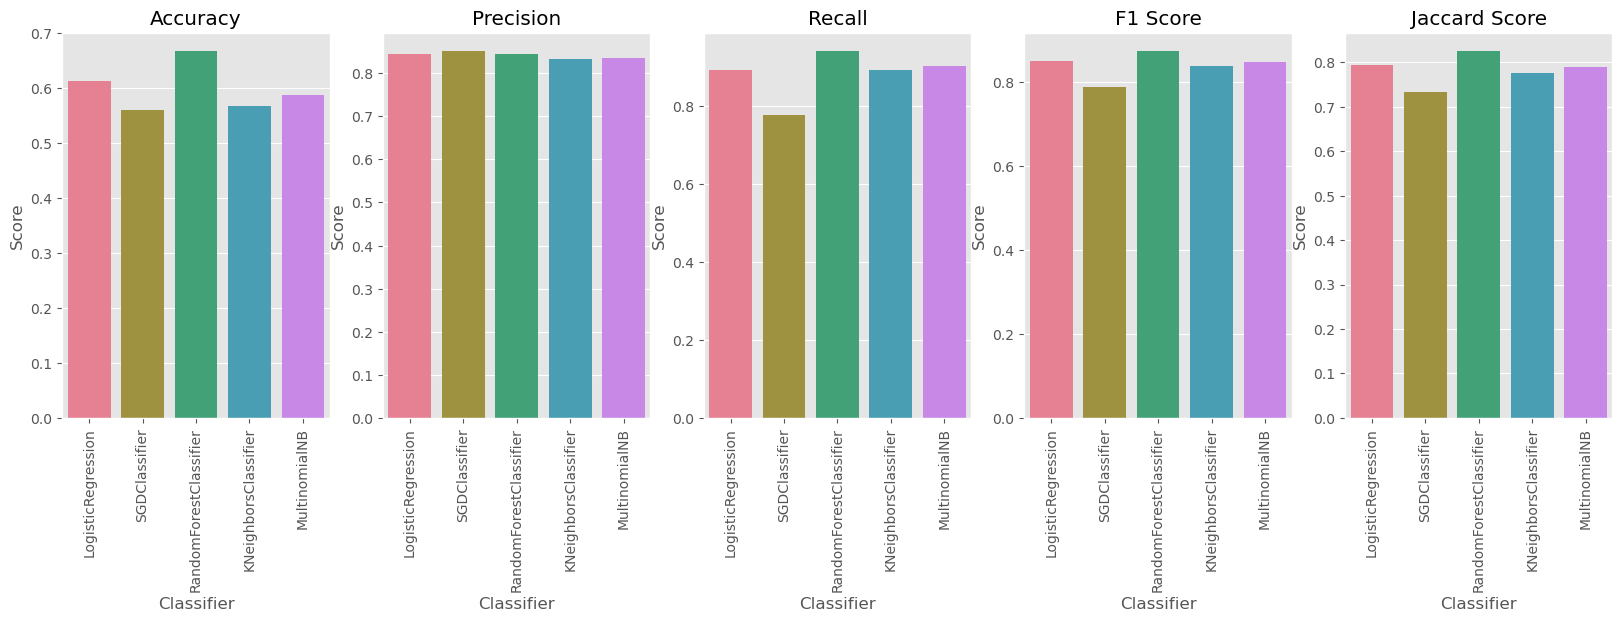

In [157]:
# Call the plot_results function
plot_results(results_df_TfidfVectorizer)

Le RandomForestClassifier obtient les meilleurs scores, peu importe le vectorizer utilisé.

In [173]:
results_RFC = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Jaccard Score'])
results_RFC = results_RFC.append(results_df_CountVectorizer.iloc[2,1:]).reset_index(drop=True)
results_RFC = results_RFC.append(results_df_TfidfVectorizer.iloc[2,1:]).reset_index(drop=True)
results_RFC['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
# results_RFC = results_RFC.set_index([['CountVectorizer', 'TfidfVectorizer']])
results_RFC

,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Classifier
0,0.6725,0.8479,0.9429,0.8752,0.8283,CountVectorizer
1,0.6675,0.8450,0.9417,0.8727,0.8250,TfidfVectorizer


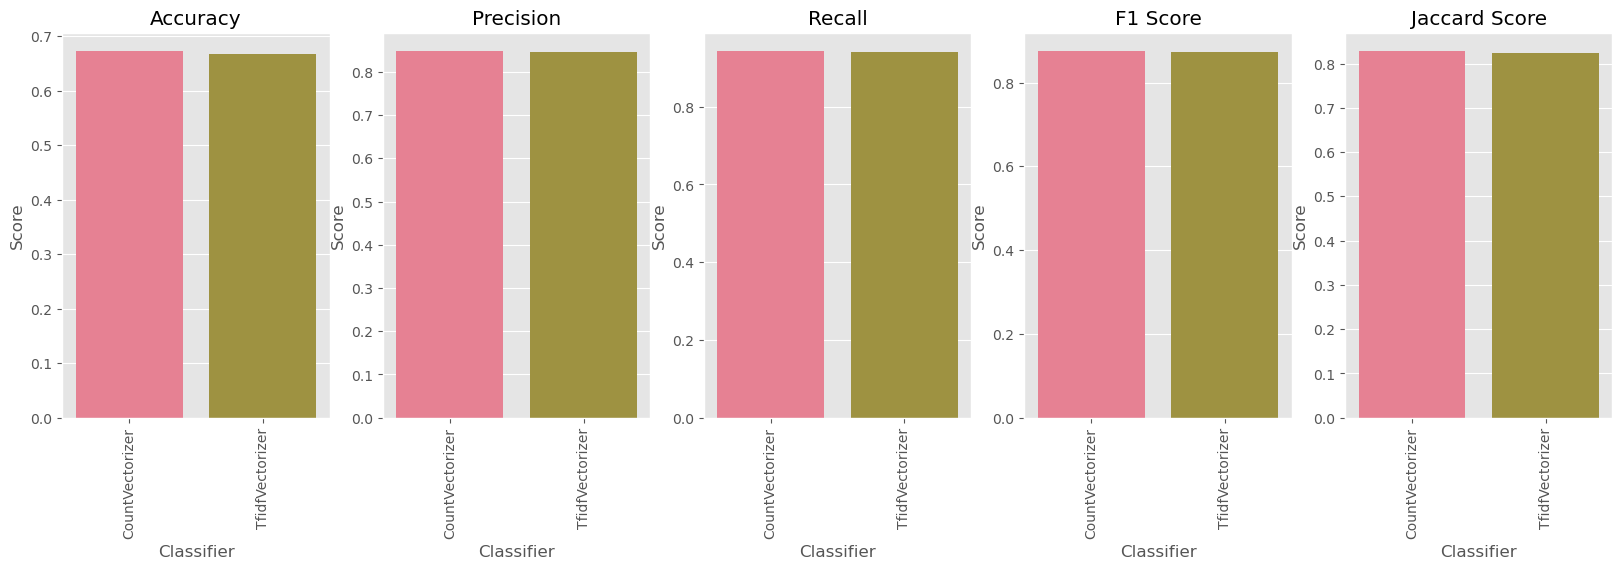

In [174]:
# Call the plot_results function
plot_results(results_RFC)

## <font color="#114b98" id="section_4">4. Approche supervisée avec Word Embedding : Word2Vec</font>

In [91]:
from gensim.models import Word2Vec
from sklearn.svm import SVC

In [92]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [120]:
# Train a Word2Vec model on the text data
model = Word2Vec(texts_list, vector_size=10000, window=2, min_count=1, workers=-1)

In [121]:
# Create feature vectors for the text data by averaging the word vectors
X = []
for text in texts_list:
    feature_vec = np.zeros(10000)
    n_words = 0
    for word in text:
        if word in model.wv:
            feature_vec = np.add(feature_vec, model.wv[word])
            n_words += 1
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    X.append(feature_vec)

In [122]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [123]:
# Train a naive bayes classifier on the training data, and make predictions on the test data
start_time = time.time()

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end_time = time.time()
print("Time taken: ", end_time - start_time)

Time taken:  32.55852460861206


In [124]:
# Evaluate the model's accuracy
print(accuracy_score(y_test, y_pred))

0.0025


## <font color="#114b98" id="section_5">5. Approche supervisée avec Word Embedding : BERT</font>

In [ ]:
# !pip install transformers

In [ ]:
# !pip install --user TensorFlow

In [ ]:
# !pip install torch

In [ ]:
# conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [126]:
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
import torch
import torchvision

In [127]:
# Load the BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [128]:
# Encode the text data as input for the BERT model
input_ids = []
attention_masks = []
for text in flat_texts:
    encoded_text = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512, pad_to_max_length=True)
    input_ids.append(encoded_text["input_ids"])
    attention_masks.append(encoded_text["attention_mask"])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [129]:
# Convert the lists to PyTorch tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(flat_tags)

ValueError: too many dimensions 'str'

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2)

In [ ]:
# Create a DataLoader for the training set
train_dataloader = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)

In [ ]:
# Create an optimizer and scheduler for fine-tuning the BERT model
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 5)

In [ ]:
# Fine-tune the BERT model on the training data
for epoch in range(5):
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks)
        loss = criterion(outputs[0], labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
# Make predictions on the test data
model.eval()
with torch.no_grad():
    test_logits = model(X_test, attention_mask=attention_masks)

In [ ]:
# Convert the logits to predictions
test_preds = torch.argmax(test_logits, axis=1)

In [ ]:
# Evaluate the model's accuracy on the test data
print(accuracy_score(y_test, test_preds))

## <font color="#114b98" id="section_6">6. Approche supervisée avec Sentence Embedding : USE</font>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow_hub

In [130]:
import tensorflow_hub as hub
import tensorflow as tf

In [131]:
# Load the USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [132]:
# Encode the text data as input for the USE model
X = use_model(flat_texts).numpy()

In [133]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [134]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [135]:
# Train a classifier on the encoded text data
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(flat_tags)), activation='softmax')
])

In [136]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [137]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5


UnimplementedError:  Cast string to float is not supported
	 [[node sparse_categorical_crossentropy/Cast (defined at \AppData\Local\Temp\ipykernel_10936\4076159209.py:1) ]] [Op:__inference_train_function_5171]

Function call stack:
train_function


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Evaluate the model's accuracy on the test data
print(accuracy_score(y_test, y_pred))